# Multiome Analysis -PART2 ATAC-Seq

# Setup

In [1]:
import scanpy as sc
import numpy as np
import re
import os
import pandas as pd
import seaborn as sb
import matplotlib

import matplotlib as mpl
from scipy import stats as scistats
import matplotlib.pyplot as pl
import scanpy.external as sce
from matplotlib import colors
import bbknn
from pathlib import Path
sc._settings.ScanpyConfig.n_jobs=8

pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0, 1, 10)), pl.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

import muon as mu
# Import a module with ATAC-seq-related functions
from muon import atac as ac

%matplotlib inline
import panel as pn
#pn.extension(sizing_mode="stretch_width", comms='colab')
pn.extension( comms='colab')


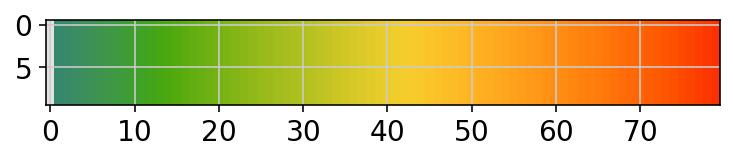

In [2]:
import colorcet as cc

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.8,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
pl.imshow(xs, cmap=mymap);  # use tab completion to choose

In [3]:
# add extra code to the path
import sys
sys.path.append('/content/sctoolkit/sctoolkit/')
from proportions import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [4]:
%load_ext watermark
%watermark
%watermark --iversions -v -m -p numpy,scipy,sklearn,anndata,scanpy,muon,pysam

Last updated: 2022-07-13T19:03:44.401147+00:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

numpy  : 1.21.6
scipy  : 1.8.0
sklearn: 0.0
anndata: 0.7.8
scanpy : 1.9.1
muon   : 0.1.2
pysam  : 0.19.1

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

muon      : 0.1.2
pandas    : 1.2.5
scipy     : 1.8.0
bbknn     : 1.5.1
sys       : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
seaborn   : 0.11.2
panel     : 0.13.1
matplotlib: 3.5.2
colorcet  : 3.0.0
logging   : 0.5.1.2
scanpy    : 1.9.1
re        : 2.2.1
numpy     : 1.21.6



# Setup working directory

Change WD to the ouput folder in the RNA 

In [5]:
%cd Multiome

[Errno 2] No such file or directory: 'Multiome'
/home/jovyan/work/Multiome


# Setup WD

In [6]:
#Change XXX to sample name
#folder='/content/'
samplename='Cell_Lines_all_Atac'
random_state=42

import os

if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

# Load the muon object

In [7]:
mdata = mu.read("Cell_lines.h5mu")
mdata

MuData object with n_obs × n_vars = 3737 × 182015
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	2901 x 21202
      obs:	'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'QC', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'leiden_r0.1', 'annotated'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
      uns:	'annotated_colors', 'dendrogram_leiden_r0.1', 'group_colors', 'hvg', 'leiden', 'leiden_r0.1_colors', 'leiden_r0.2_colors', 'leiden_r0.4_colors', 'neighbors', 'pca', 'pearson_residuals_normalization', 'sample_colors', 'scrublet', 'umap', 'wilcoxon'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'normalized', 'raw', 'sqrt_norm'
      obsp:	'connectivities', 'distances'
    atac:	3737 x 160813
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

# Creating a New object with only the atac layer

In [8]:
atac = mdata.mod['atac']
atac.obs['sample']=[samplename]*atac.n_obs
atac.obs['group']=[samplename]*atac.n_obs
atac

AnnData object with n_obs × n_vars = 3737 × 160813
    obs: 'sample', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [9]:
# Quality control - calculate QC covariates
atac.obs['n_counts'] = atac.X.sum(1)
atac.obs['log_counts'] = np.log(atac.obs['n_counts'])
atac.obs['n_genes'] = (atac.X > 0).sum(1)

sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

atac

AnnData object with n_obs × n_vars = 3737 × 160813
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [10]:
atac.obs

,sample,group,n_counts,log_counts,n_genes,n_genes_by_counts,total_counts
AAACAGCCAAACTGTT-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,2658.0,7.885329,1440,1440,2658.0
AAACAGCCAAGGACCA-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,10488.0,9.257987,5324,5324,10488.0
AAACATGCAAGGATTA-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,9782.0,9.188299,5057,5057,9782.0
AAACATGCAGTAGGTG-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,8224.0,9.014812,4239,4239,8224.0
AAACCAACATAGACTT-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,6286.0,8.746080,3244,3244,6286.0
...,...,...,...,...,...,...,...
TTTGTGGCACAATTAC-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,9349.0,9.143024,4999,4999,9349.0
TTTGTGTTCCGGAACC-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,5496.0,8.611775,2933,2933,5496.0
TTTGTTGGTTGCACAA-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,10017.0,9.212039,5192,5192,10017.0
TTTGTTGGTTTGAGCA-1,Cell_Lines_all_Atac,Cell_Lines_all_Atac,6809.0,8.826000,3495,3495,6809.0


In [11]:
atac.var

,gene_ids,feature_types,genome,interval,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
chr1:9806-10702,chr1:9806-10702,Peaks,GRCh38,chr1:9806-10702,43,0.024083,98.849344,90.0
chr1:180664-181351,chr1:180664-181351,Peaks,GRCh38,chr1:180664-181351,83,0.041210,97.778967,154.0
chr1:183906-184762,chr1:183906-184762,Peaks,GRCh38,chr1:183906-184762,25,0.013647,99.331014,51.0
chr1:191046-191829,chr1:191046-191829,Peaks,GRCh38,chr1:191046-191829,73,0.036928,98.046561,138.0
chr1:267560-268455,chr1:267560-268455,Peaks,GRCh38,chr1:267560-268455,32,0.016591,99.143698,62.0
...,...,...,...,...,...,...,...,...
KI270711.1:7864-8747,KI270711.1:7864-8747,Peaks,GRCh38,KI270711.1:7864-8747,28,0.013915,99.250736,52.0
KI270711.1:22570-23437,KI270711.1:22570-23437,Peaks,GRCh38,KI270711.1:22570-23437,34,0.017661,99.090179,66.0
KI270713.1:15013-15920,KI270713.1:15013-15920,Peaks,GRCh38,KI270713.1:15013-15920,27,0.014450,99.277495,54.0
KI270713.1:21394-22288,KI270713.1:21394-22288,Peaks,GRCh38,KI270713.1:21394-22288,513,0.311480,86.272411,1164.0


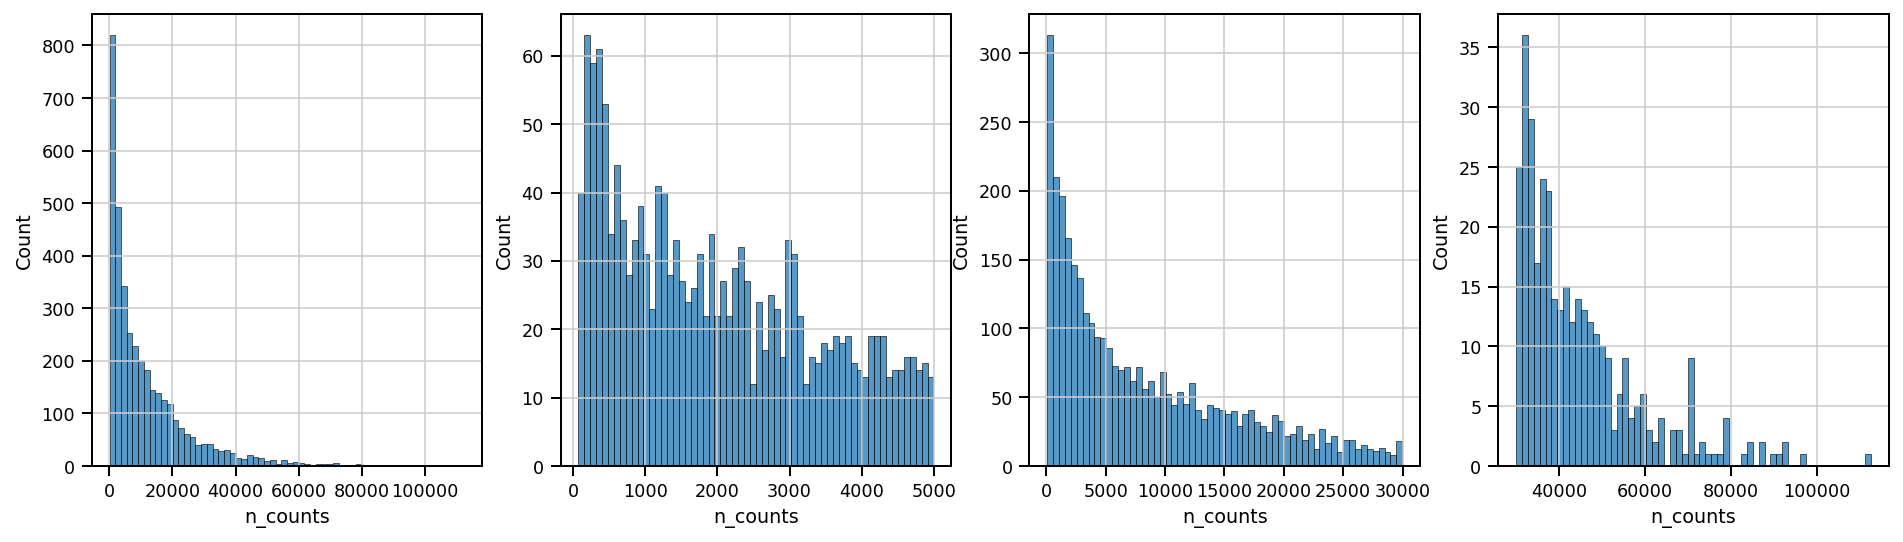

In [12]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(atac.obs['n_counts'], kde=False, ax=ax1,)
ax2_dict =  sb.histplot(atac.obs['n_counts'][atac.obs['n_counts']<5000], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(atac.obs['n_counts'][atac.obs['n_counts']<30000], kde=False, bins=60, ax=ax3,)
ax4_dict = sb.histplot(atac.obs['n_counts'][atac.obs['n_counts']>30000], kde=False, bins=60, ax=ax4, )
savefig='figures/'+samplename + '_1_QC_counts_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

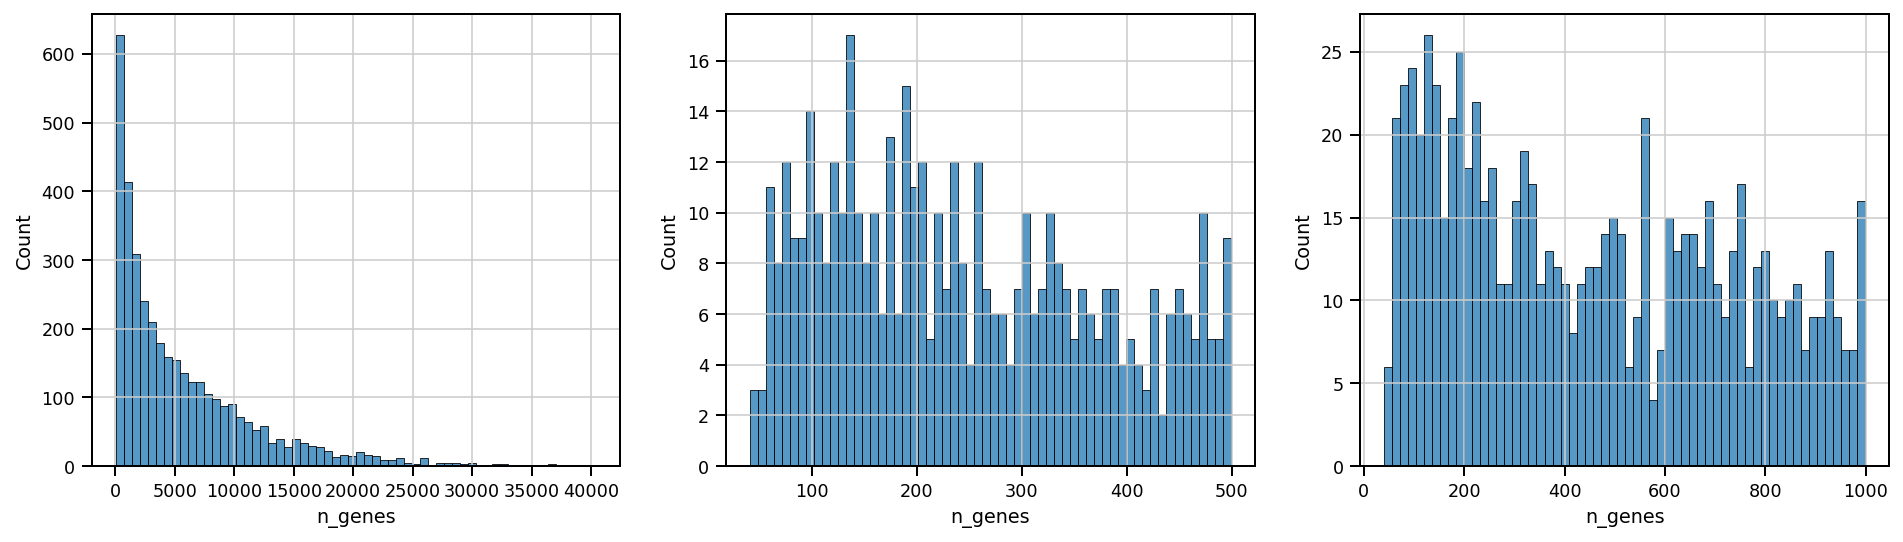

In [13]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(atac.obs['n_genes'], kde=False, bins=60, ax=ax1,)
ax2_dict =  sb.histplot(atac.obs['n_genes'][atac.obs['n_genes']<500], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(atac.obs['n_genes'][atac.obs['n_genes']<1000], kde=False, bins=60, ax=ax3,)
savefig='figures/'+samplename + '_2_QC_gene_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

In [14]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)#remove all peaks not exp in atleast 10 cells
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

Filter cells

In [15]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

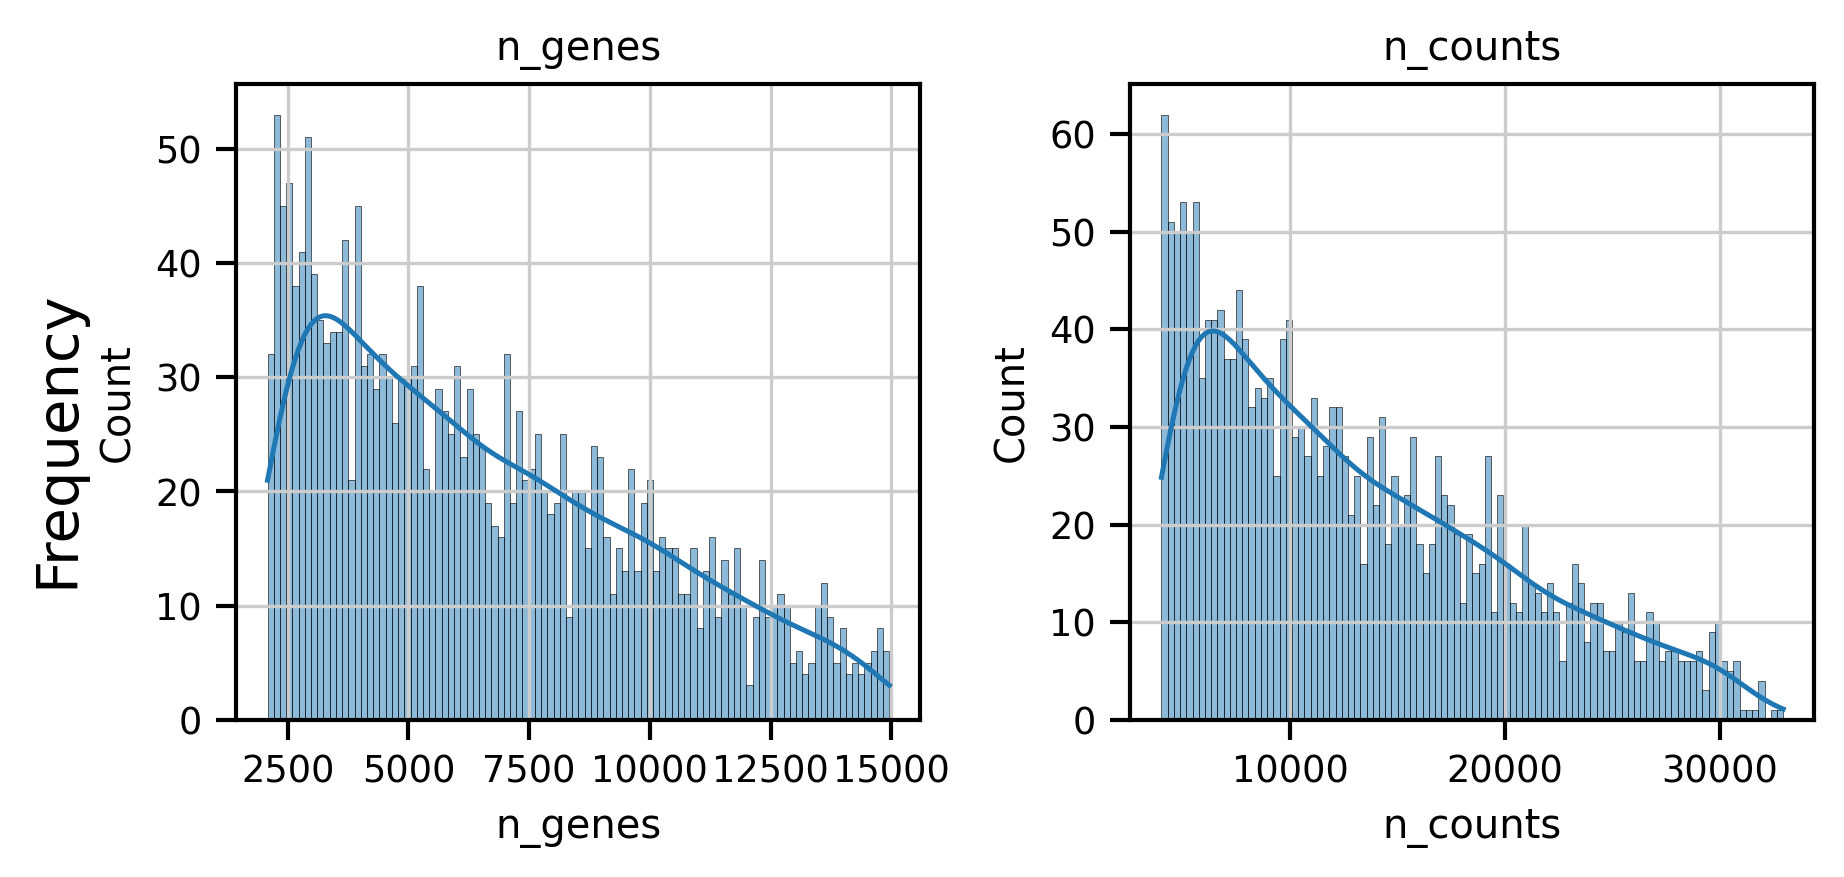

In [16]:

sb.set_context('paper')


fig, (ax1, ax2,) = pl.subplots(1, 2, figsize=(6, 3), dpi=150, sharey=False)
atac.obs['n_genes']

sb.histplot( atac.obs['n_genes'], ax=ax1, kde=True, bins=100)
sb.histplot( atac.obs['n_counts'], ax=ax2, kde=True, bins=100)

ax1.title.set_text('n_genes')
ax2.title.set_text('n_counts')

fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
savefig='figures/'+samplename + '_3_QC_filtering_postfilter.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

... storing 'sample' as categorical
... storing 'group' as categorical


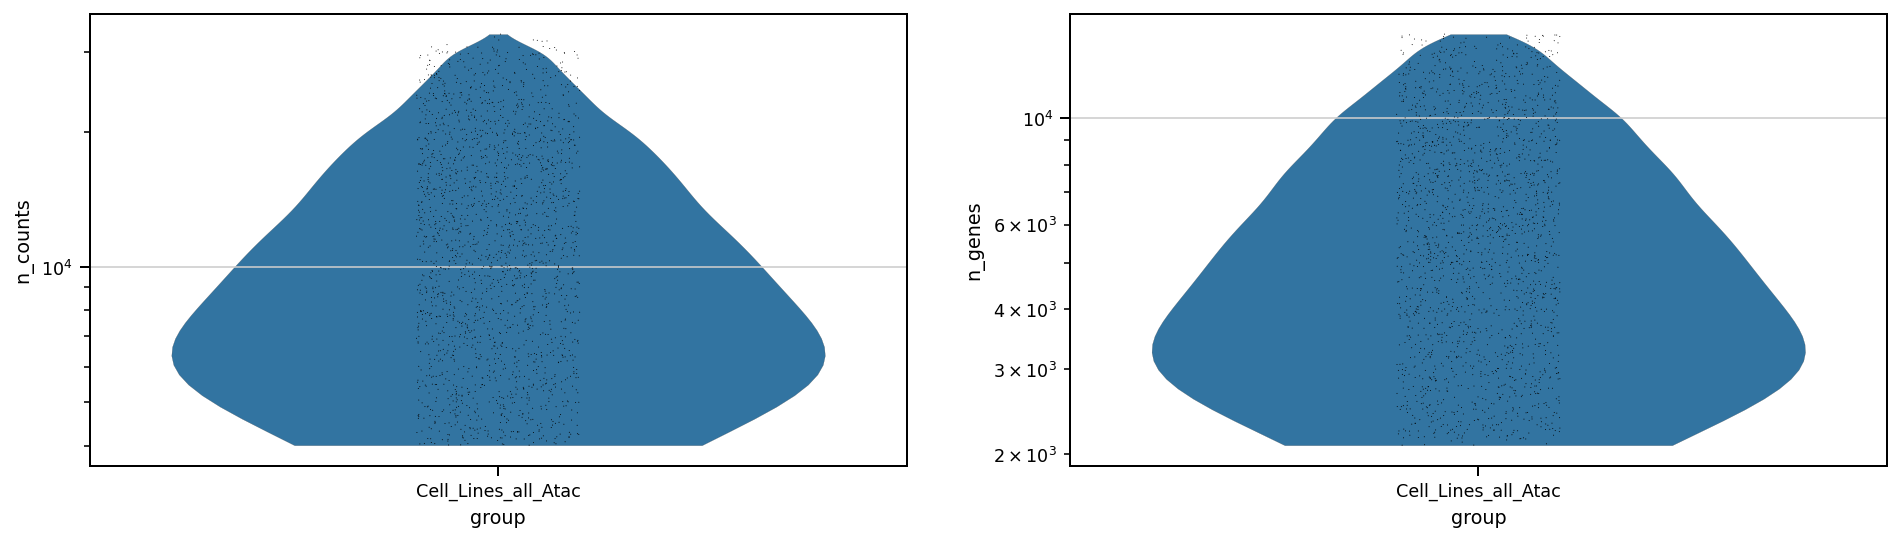

In [17]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2,) = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sc.pl.violin(atac, 'n_counts', groupby='group', size=0.5, log=True, cut=0, ax=ax1, show=False)
ax2_dict =  sc.pl.violin(atac, 'n_genes', groupby='group', size=0.5, log=True, cut=0, ax=ax2, show=False)

savefig='figures/'+samplename + '_5_QC_violin_plots.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

# Nucleosome signal
Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

 The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called nucleosome signal, and it can be estimated using a subset of fragments with muon.atac.tl.nucleosome_signal().

Fragment size distribution can be estimated from a subset of data and plotted with muon.atac.pl.fragment_histogram(), and the nucleosome signal can visualised with a general function mu.pl.histogram():

In [18]:
atac.obs['NS']=1

In [19]:
from muon import atac as ac

Fetching Regions...: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


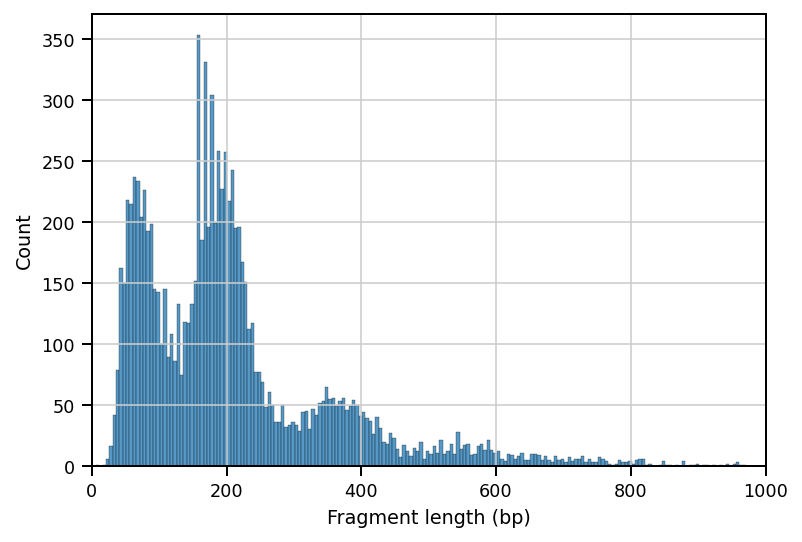

In [20]:
ac.pl.fragment_histogram(atac, region='chr3:1-2000000') #signal -peaks prop to size off nucleiosome 

## Plot nucleosome signal distribution across cells

Computes the ratio of nucleosomal cut fragments to nucleosome-free fragments per cell. Nucleosome-free fragments are shorter than 147 bp while mono-mucleosomal fragments are between 147 bp and 294 bp long.

In [21]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:04<00:00, 230015.38it/s]


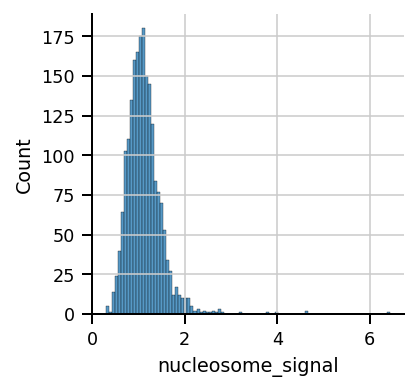

In [22]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
mu.pl.histogram(atac, "nucleosome_signal", kde=False)#as high as possible 

# TSS enrichment
We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites can be obtained from the interval field of the gene annotation in the rna modality:

TSS enrichment function muon.atac.tl.tss_enrichment() will return an AnnData object with n_obs x bases dimensions where bases correspond to positions around TSS and are defined by extend_upstream and extend_downstream parameters, each of them being 1000 bp by default. It will also record tss_score in the .obs of the original ATAC object.

In [23]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)
#enricmt of fragments near to transcriptn start pt 

Fetching Regions...: 100%|██████████| 1000/1000 [00:03<00:00, 260.03it/s]


In [24]:
tss

AnnData object with n_obs × n_vars = 2035 × 2001
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

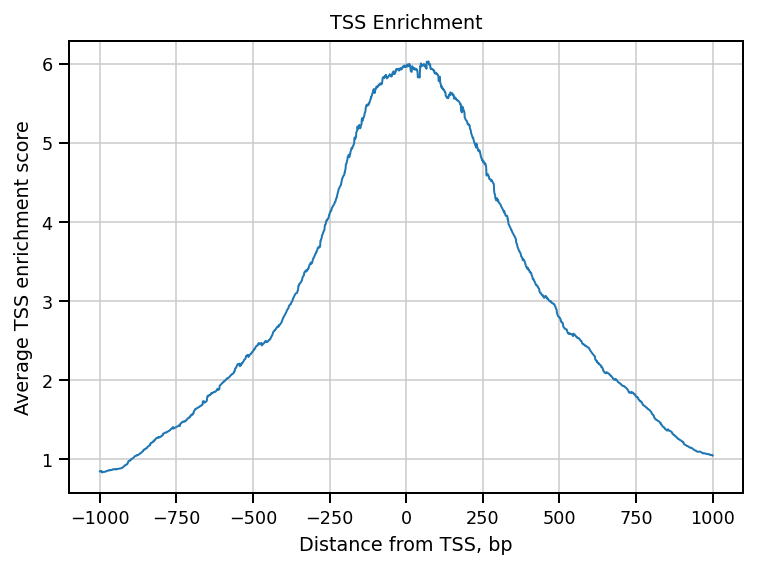

In [25]:
pl.rcParams['lines.linewidth'] = 1
ac.pl.tss_enrichment(tss)

# Normalization

In [26]:
# Save original counts
atac.layers["counts"] = atac.X

In [27]:
atac.X=atac.layers["counts"]

There can be multiple options for ATAC-seq data normalisation.

One is latent semantic indexing that is frequently used for processing ATAC-seq datasets. First, it constructs term-document matrix from the original count matrix. Then the singular value decomposition (SVD) — the same technique that convential principal component analysis uses — is used to generate LSI components. 

TF-IDF normalisation is implemented in the muon’s ATAC module:

In [28]:
#ac.pp.tfidf(atac, scale_factor=1e4)--------peaks per 10k 

Another option is to use log-normalisation correcting for the total number of counts per cell and log-transforming the values. This is a typical normalisation for many scRNA-seq workflows, and it’s typically followed by PCA to generate latent components. Analysing multimodal scRNA-seq & scATAC-seq datasets we notice this scATAC-seq normalisation yields PC & UMAP spaces similar to the ones generated on scRNA-seq counts.

In [29]:
import scanpy as sc
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)

Since scATAC-seq count matrix is very sparse and most non-zero values in it are 1 and 2, some workflows also binarise the matrix prior to its downstream analysis:

In [30]:
#ac.pp.binarize(atac)

# Feature selection

In [31]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=0.5) #highly variable peaks 

/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:541: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:542: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

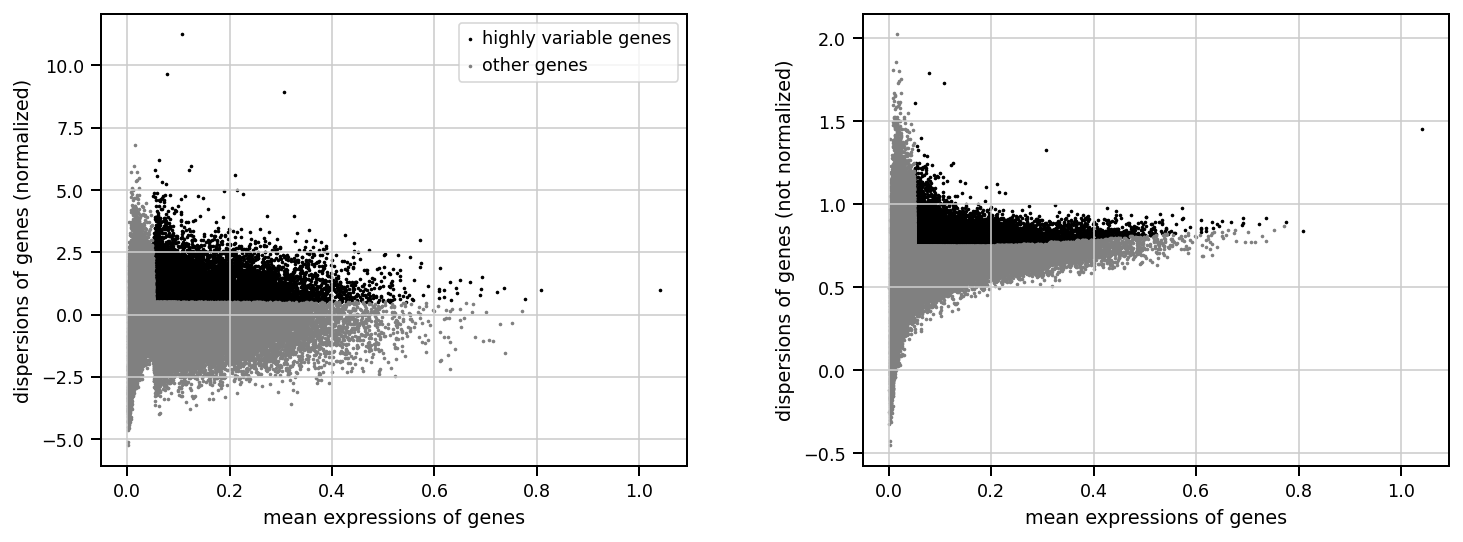

In [32]:
sc.pl.highly_variable_genes(atac)

In [33]:
np.sum(atac.var.highly_variable)

15424

In [34]:
atac.raw = atac

# Analysis
After filtering out low-quality cells, normalising the counts matrix, and selecting highly varianbe peaks, we can already use this data for multimodal integration.

However, as in the case of gene expression, we will study this data individually first and will run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types. This might be useful later to compare cell type definition between modalities.

In [35]:
#ac.tl.lsi(atac)

In [36]:
#atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
#atac.varm["LSI"] = atac.varm["LSI"][:,1:]
#atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [37]:
#sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=10)

# Scaling

# PCA

In [38]:
sc.pp.scale(atac)
sc.tl.pca(atac)

/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


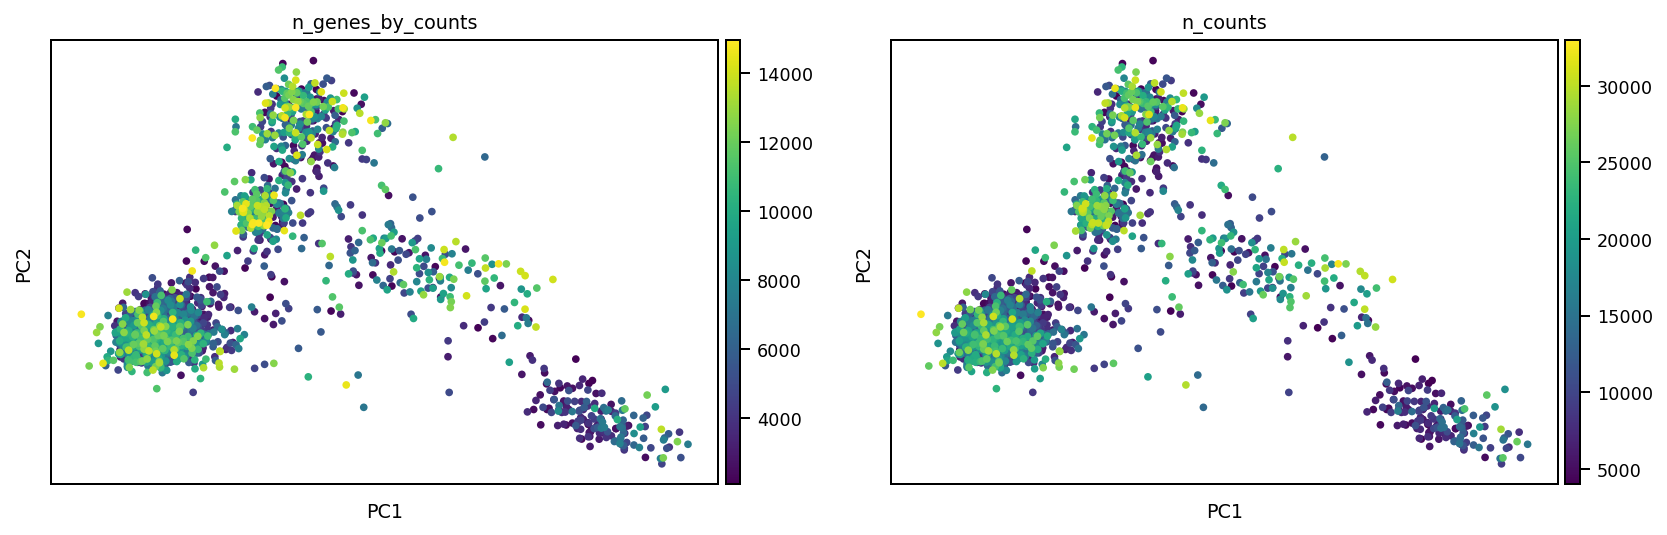

In [39]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

Peak Annotation

With muon’s ATAC module, we can plot average values for cut counts in peaks of different types (promoter/distal) that are assigned to respective genes — just by providing gene names.

For that to work, we need the peak annotation table with gene -> peak correspondence. The peak_annotation.tsv file was detected and loaded automatically when we loaded the original data. Here is how the processed peak annotation table looks like:

In [40]:
atac.uns['atac']['peak_annotation'].tail()

# Alternatively add peak annotation from a TSV file
# ac.tl.add_peak_annotation(atac, annotation="data/pbmc10k/atac_peak_annotation.tsv")

,peak,distance,peak_type
gene_name,,,
AC240274.1,KI270711.1:7864-8747,15903,distal
AC240274.1,KI270711.1:22570-23437,1213,distal
AC213203.2,KI270713.1:15013-15920,16608,distal
AC213203.2,KI270713.1:21394-22288,10240,distal
AC213203.2,KI270713.1:28205-28936,3592,distal


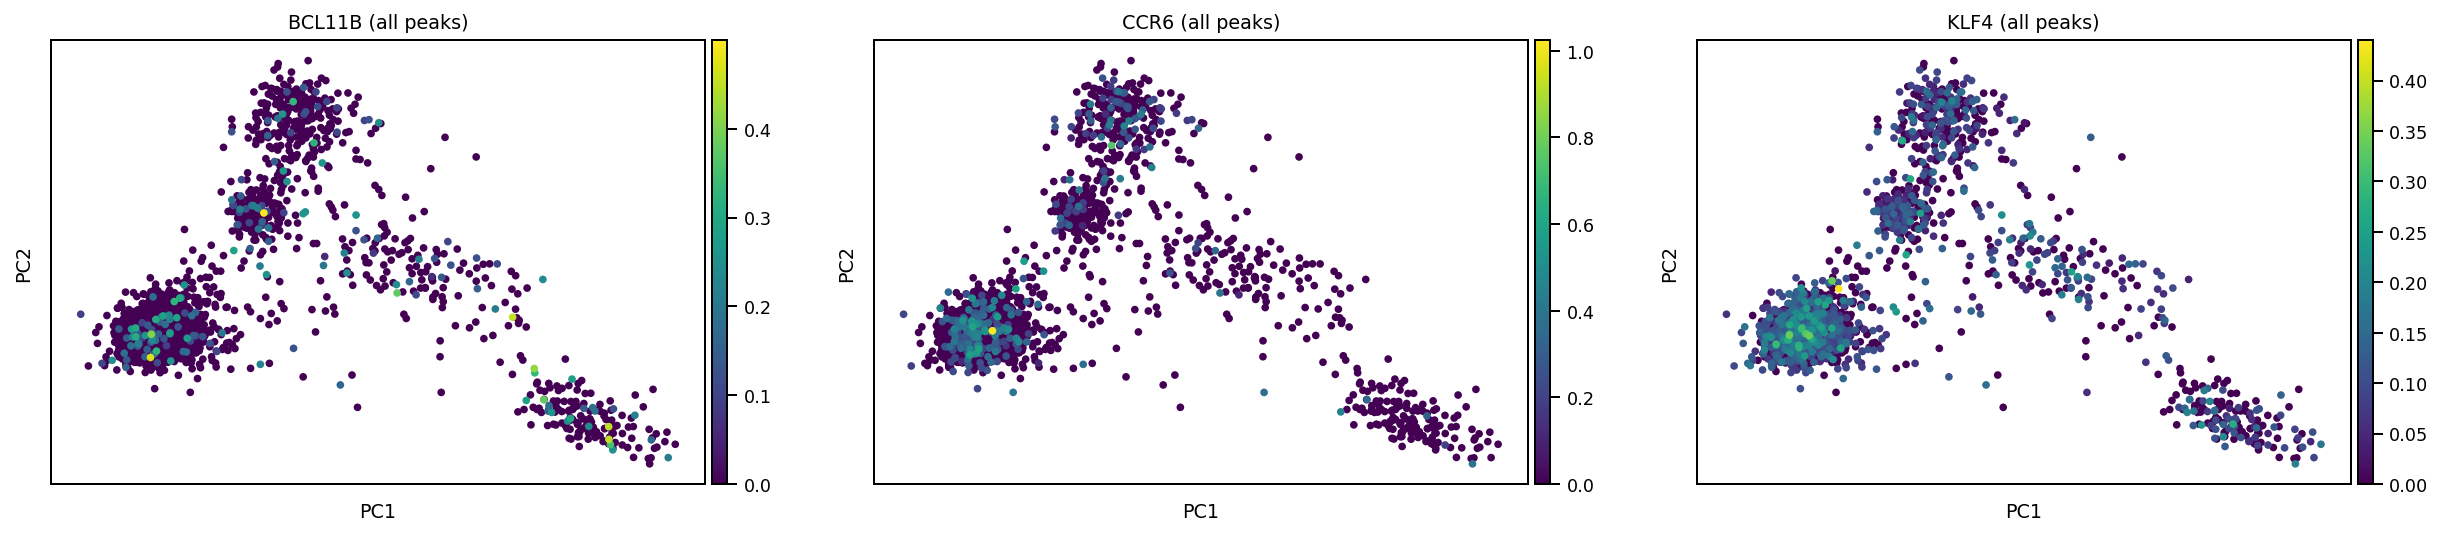

In [41]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4"], average="total")

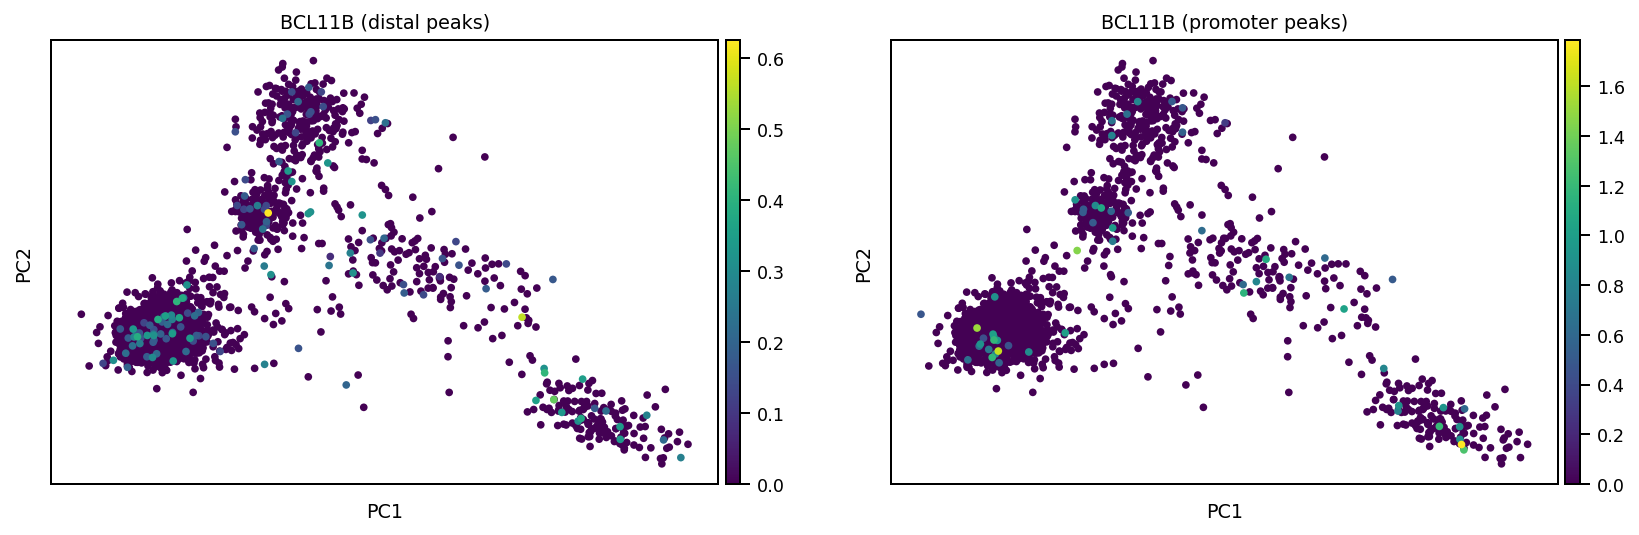

In [42]:
ac.pl.pca(atac, color="BCL11B", average="peak_type")

In [43]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

# Non-linear dimensionality reduction and clustering¶

In [44]:
sc.tl.leiden(atac, resolution=.5)

In [45]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=42)

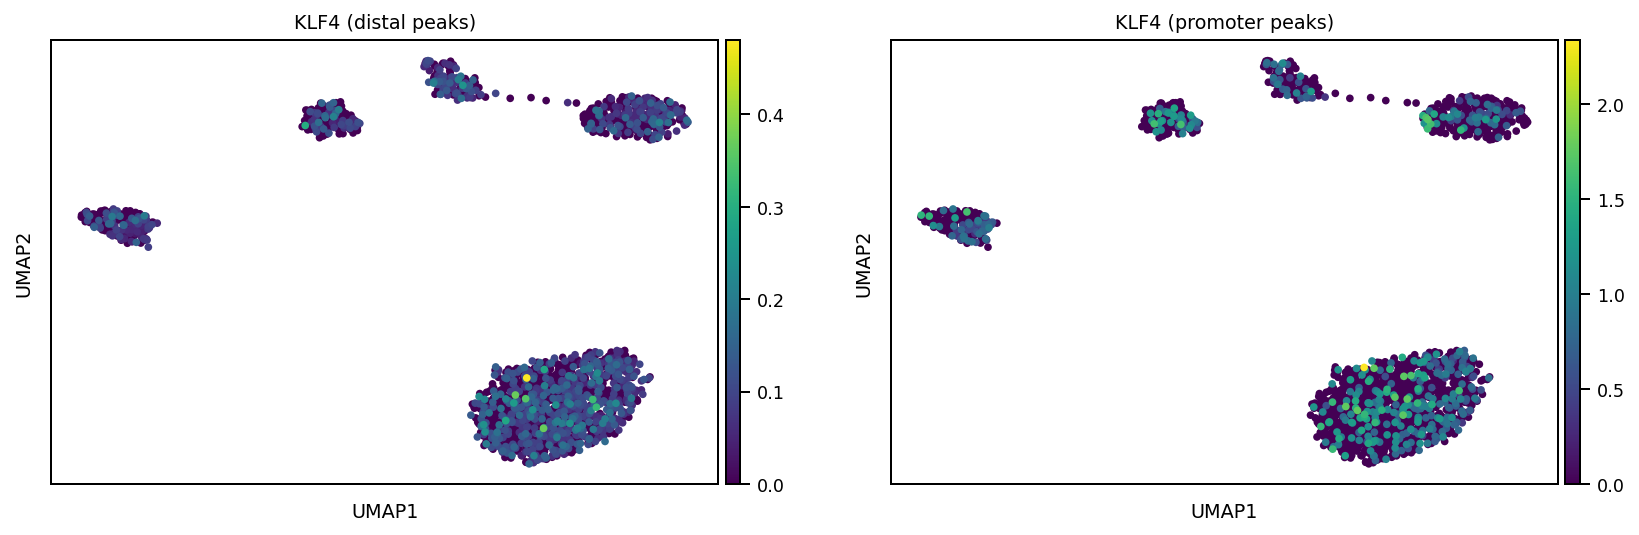

In [46]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type") #peaks as annotated near to transcriptnl starting points : oromoter ; other regions of chr open - affecting --

In [47]:
atac.var

,gene_ids,feature_types,genome,interval,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
chr1:9806-10702,chr1:9806-10702,Peaks,GRCh38,chr1:9806-10702,43,0.024083,98.849344,90.0,False,0.014734,0.436574,-0.930647,0.009214,0.088690
chr1:180664-181351,chr1:180664-181351,Peaks,GRCh38,chr1:180664-181351,83,0.041210,97.778967,154.0,False,0.032661,0.551839,-0.370035,0.020041,0.132719
chr1:183906-184762,chr1:183906-184762,Peaks,GRCh38,chr1:183906-184762,25,0.013647,99.331014,51.0,False,0.010267,0.339203,-1.404233,0.006543,0.073713
chr1:191046-191829,chr1:191046-191829,Peaks,GRCh38,chr1:191046-191829,73,0.036928,98.046561,138.0,False,0.027190,0.689748,0.300715,0.016024,0.122514
chr1:267560-268455,chr1:267560-268455,Peaks,GRCh38,chr1:267560-268455,32,0.016591,99.143698,62.0,False,0.017782,0.888304,1.266429,0.009629,0.101864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KI270711.1:7864-8747,KI270711.1:7864-8747,Peaks,GRCh38,KI270711.1:7864-8747,28,0.013915,99.250736,52.0,False,0.009007,0.411185,-1.054133,0.005649,0.069283
KI270711.1:22570-23437,KI270711.1:22570-23437,Peaks,GRCh38,KI270711.1:22570-23437,34,0.017661,99.090179,66.0,False,0.011513,0.228106,-1.944576,0.007579,0.076706
KI270713.1:15013-15920,KI270713.1:15013-15920,Peaks,GRCh38,KI270713.1:15013-15920,27,0.014450,99.277495,54.0,False,0.015586,0.880882,1.230332,0.008406,0.095665
KI270713.1:21394-22288,KI270713.1:21394-22288,Peaks,GRCh38,KI270713.1:21394-22288,513,0.311480,86.272411,1164.0,True,0.252784,0.783585,0.889876,0.154902,0.377996


# Marker genes and celltypes

In [48]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [49]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option("max_columns", 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,3_g,3_p,4_n,4_g,4_p,5_n,5_g,5_p
0,chr3:73437690-73438585,PDZRN3,7.323507e-46,chr17:60599640-60600490,PPM1D,1.513074e-14,chr3:75435038-75435941,LINC02018,4.554691e-37,chr8:29615004-29615873,AC084026.1,3.743901e-15,chr7:36303144-36304018,AC006960.3,1.453243e-16,chr12:13098010-13098896,GSG1,1.173910e-11
1,chr3:57597107-57598026,"ARF4-AS1, ARF4",1.771723e-28,chr7:29208190-29209053,"AC004593.3, CHN2, AC004593.1",2.543989e-14,chr12:5096031-5096943,AC005906.3,5.265146e-26,chr6:44256866-44257786,SLC35B2,8.327808e-14,chr8:66546352-66547261,VXN,7.580931e-15,chr22:32712583-32713456,"Z73495.1, SYN3",6.428437e-11
2,chr7:674699-675598,PRKAR1B,6.721236e-24,chr7:46215757-46216670,AC023669.1,2.282272e-13,chr12:6851900-6852796,"CDCA3, USP5",6.257774e-25,chr22:16601046-16601791,AP000547.3,3.858874e-13,chr7:19958026-19958844,AC005062.1,1.610221e-14,chr19:42889386-42890308,PSG1,9.531746e-11
3,chr7:42649825-42650708,LINC01448,1.799024e-22,chr7:157289322-157290043,AC004975.2,4.694740e-13,chr12:6533384-6534035,AC006064.3,1.646553e-23,chr6:42260441-42261352,"TRERF1, MRPS10",6.021775e-13,chr8:66123643-66124562,TRIM55,5.738213e-14,chr8:133036559-133037473,"TG, SLA, AF305872.2",1.072161e-10
4,chr3:57692409-57693333,"DENND6A, DENND6A-DT",2.019170e-22,chr3:58237182-58238119,ABHD6,4.915346e-13,chr12:6336085-6336919,TNFRSF1A,2.694651e-23,chr8:38012836-38013755,EIF4EBP1,1.552778e-12,chr1:115179238-115180096,LINC01765,2.253342e-13,chr14:28766185-28767108,FOXG1,1.270740e-10
5,chr7:2298738-2299648,SNX8,3.731504e-22,chr3:72231138-72232020,LINC00877,7.046219e-13,chr18:23994213-23995132,"TTC39C, TTC39C-AS1",1.099187e-22,chr7:63925947-63926781,AC092634.8,1.550143e-12,chr8:61053939-61054839,AC022182.2,2.989937e-13,chr7:157564570-157565410,"AC005481.1, PTPRN2",2.375274e-10
6,chr7:42176158-42177031,GLI3,5.322885e-22,chr7:28509489-28510314,CREB5,4.829334e-12,chr11:119095124-119095962,H2AFX,1.804852e-22,chr4:21173516-21174403,KCNIP4,2.970631e-12,chr8:141227879-141228628,SLC45A4,1.609942e-12,chr12:10031377-10032238,CLEC9A,2.544570e-10
7,chr2:3041692-3042629,LINC01250,8.050229e-21,chr3:72871871-72872791,GXYLT2,5.143964e-12,chr18:23586300-23587190,NPC1,1.001487e-21,chr15:89462282-89463169,RHCG,7.533574e-12,chr10:46524528-46525444,GPRIN2,2.015732e-12,chr19:50328880-50329793,KCNC3,3.801424e-10
8,chr7:25186120-25187007,C7orf31,7.010399e-20,chr3:58433366-58434281,PDHB,6.244396e-12,chr11:119056860-119057782,HYOU1,1.634496e-21,chr20:45470207-45471141,WFDC2,1.063300e-11,chr8:143518906-143519811,ZC3H3,2.717678e-12,chr12:27343189-27344117,ARNTL2,4.622827e-10
9,chr3:57227257-57228156,"APPL1, HESX1",6.444574e-20,chr3:57755727-57756634,SLMAP,6.245647e-12,chr3:64109228-64110146,"PRICKLE2, PRICKLE2-AS2",5.712581e-21,chr22:22558805-22559669,"AC246793.1, PRAME",2.829429e-11,chr8:141075398-141076276,AC100860.1,2.679479e-12,chr19:41225658-41226491,AXL,4.313091e-10


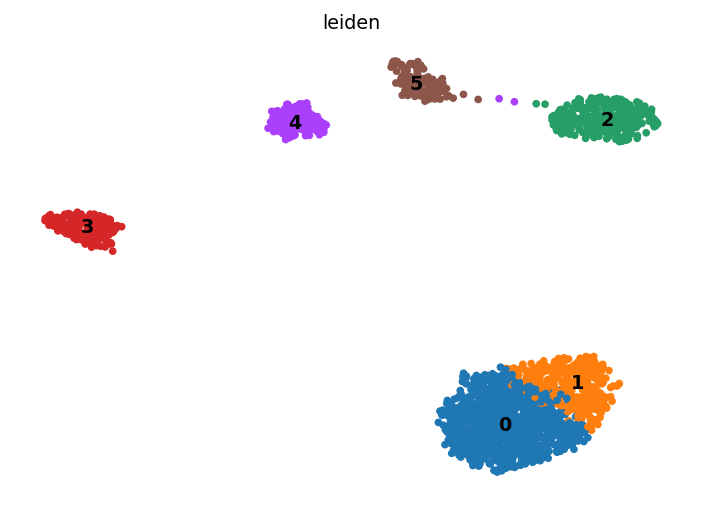

In [50]:
sc.pl.umap(atac, color=["leiden"], legend_loc="on data", frameon=False)

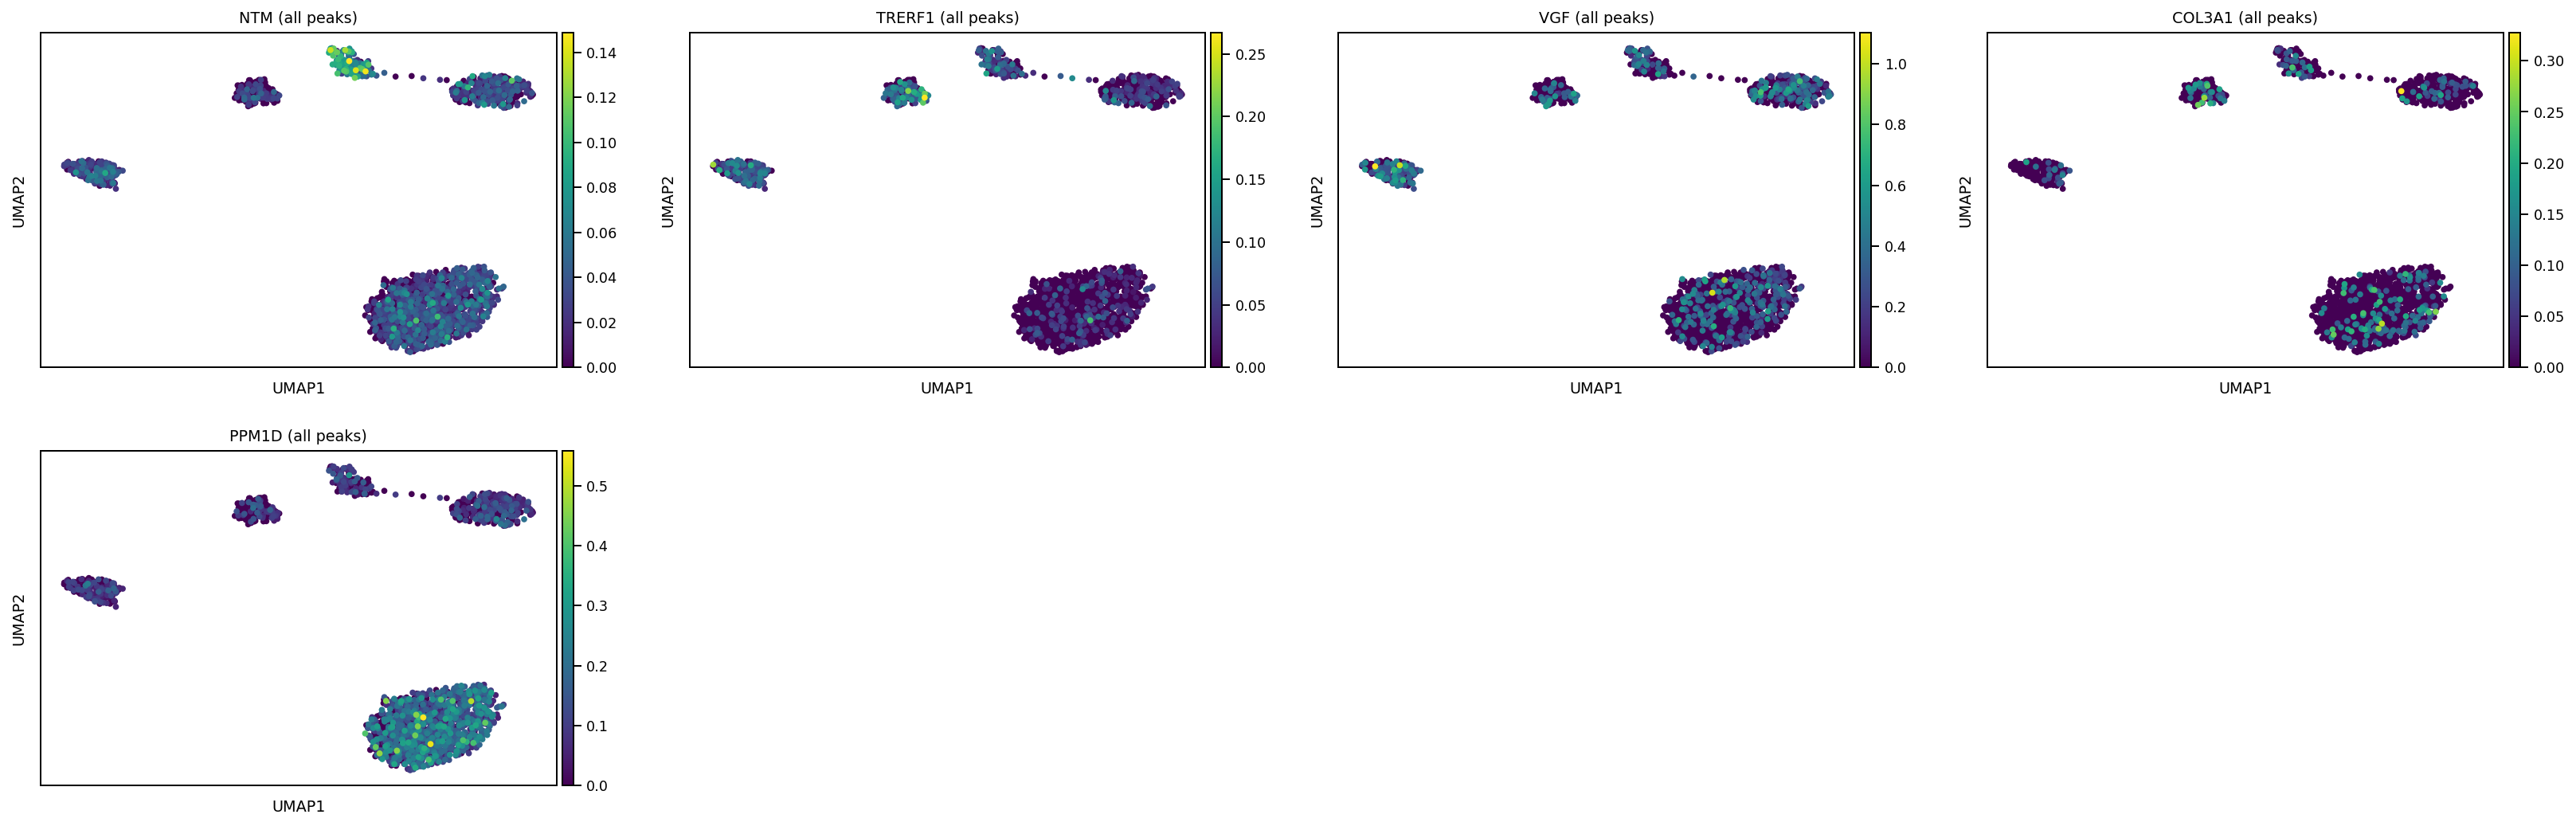

In [51]:
ac.pl.umap(atac, color=["NTM",'TRERF1','VGF','COL3A1','PPM1D'], average="total")

In [52]:
atac.obs['annotated'] = atac.obs['leiden'].cat.add_categories([ "Cell_line_1","Cell_line_2","Cell_line_3","Cell_line_4","Cell_line_5"])
atac.obs['annotated'][np.in1d(atac.obs['annotated'], ['5'])] = 'Cell_line_1'
atac.obs['annotated'][np.in1d(atac.obs['annotated'], ['4','6'])] = 'Cell_line_3'
atac.obs['annotated'][np.in1d(atac.obs['annotated'], ['3'])] = 'Cell_line_2'
atac.obs['annotated'][np.in1d(atac.obs['annotated'], ['0','1'])] = 'Cell_line_4'
atac.obs['annotated'][np.in1d(atac.obs['annotated'], ['2'])] = 'Cell_line_5'


atac.obs['annotated'] = atac.obs['annotated'].cat.remove_unused_categories()
atac

AnnData object with n_obs × n_vars = 2035 × 160775
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'leiden', 'annotated'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'files', 'group_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'rank_genes_groups', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

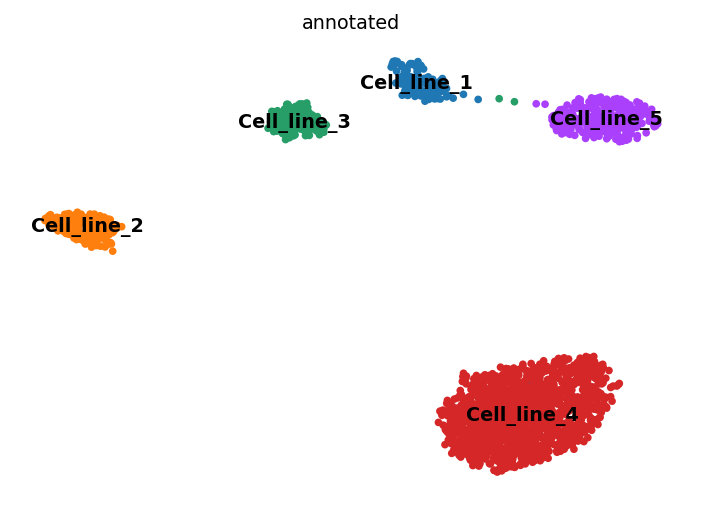

In [53]:
sc.pl.umap(atac, color=["annotated"], legend_loc="on data", frameon=False)

## Ploting markers genes from RNA

In [54]:
marker_genes=['MMP1', 'PMEL','MGP','VGF','COL3A1','LINC02109','LINC01320','ROBO2','RPS4Y1','UTY','APOE',]

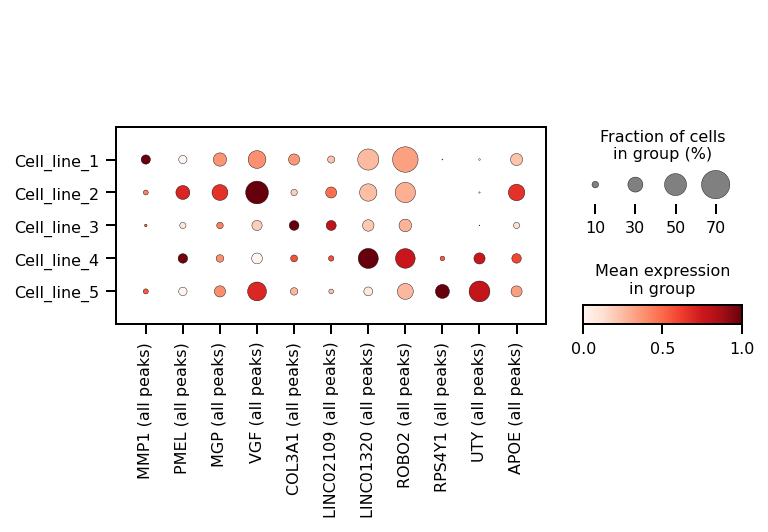

In [55]:
ac.pl.dotplot(atac, marker_genes,standard_scale='group', groupby='annotated')

# Exercise define a new set of markers for annotatting your cells using the atac seq data

In [56]:
marker_atac=['',]




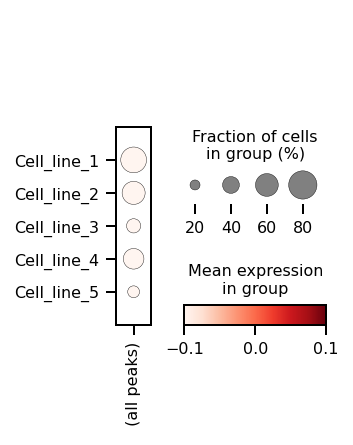

In [57]:
ac.pl.dotplot(atac, marker_atac,standard_scale='group', groupby='annotated')




Save the atact layer as .h5mu

In [58]:
mu.write("Cell_lines.h5mu/atac", atac)